# Vehicle Detection & Tracking Using Computer Vision And Machine Learning

Blablabla....

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [3]:
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

project_dataset_dir = "project_dataset"
project_dataset_vehicles_dir = "project_dataset/vehicles"
project_dataset_non_vehicles_dir = "project_dataset/non-vehicles"

# Dataset exploration

In [4]:
# Let's fetch the paths of training images
project_vehicle_img_paths = glob.glob(project_dataset_vehicles_dir + "/**/*.png", recursive=True)
len(project_vehicle_img_paths)

8792

In [5]:
project_non_vehicle_img_paths = glob.glob(project_dataset_non_vehicles_dir + "/**/*.png", recursive=True)
len(project_non_vehicle_img_paths)

8968

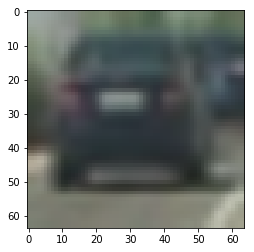

In [6]:
example_img = load_image(project_vehicle_img_paths[0])
plt.imshow(example_img)

In [7]:
class Dataset:
    """
    Represents top level information about a given dataset
    """
    def __init__(self, data_paths, labels, image_size, image_type="png"):
        self.data_paths = data_path
        self.labels = labels
        self.image_size = image_size
        self.image_type = image_type
    
    def load_data(self):
        """
        Identifies all files in the dataset and loads the images
        """
        if len(self.labels) != len(self.data_paths):
            print("Mismatch in length")
            # TODO to continue

# Feature Extraction

In this section, we apply Histogram of Oriented Gradients and Color bins to our input image to create our features, which will then be fed to a classifier. But before we employ these techniques, we must first define a function to subsample our input.

In [8]:
def subsample_image(img, new_size=(32,32), single_vector=True):
    """
    Resizes the image to the new size and returns either a 1-D vector or multi-dimensional matrix depending
    on the value of single_vector
    """
    features = cv2.resize(img, new_size)
    return features.ravel() if single_vector else features

In [9]:
def change_color_space(img, cspace="RGB"):
    """
    Takes in a RGB image and returns a new image in the target color space.
    If the current image and target image are both rgb, then a new copy of the image is returned
    """
    feature_image = None
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: 
        feature_image = np.copy(img) 
    
    return feature_image

In [10]:
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the histograms of the color image across all channels, as a concatenanted feature vector
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler


In [17]:
def compute_features(img, color_space="RGB", subsample_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                    hog_orient=6, hog_pix_per_cell=8, hog_cells_per_block=2, hog_block_norm="L2-Hys",
                    hog_color_channels=[0, 1, 2], hog_grayscale=True):
    """
    Computes the features of the given image, by using a combination of:
    - image subsampling
    - color histogram
    - histogram of gradients
    The vector contains all concatenated (and unscaled) features computed
    """
    img_cspace = change_color_space(img, cspace=color_space)
    img_sub_sample = subsample_image(img_cspace, new_size=subsample_size)
    img_color_hist = color_histogram(img, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    if hog_color_channels == None:            
        hog_features, img_hog = hog(to_grayscale(img), 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
    else:
        for ch in hog_color_channels:
            hf, img_hog = hog(img[:,:,ch], 
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualise=True, feature_vector=True)
            hog_features = hf if len(hog_features) == 0 else np.concatenate((hog_features, hf))
    
    features = np.concatenate((img_sub_sample, img_color_hist, hog_features))
    # Now stack the features on top of one another for normalization
    #stacked_features = np.vstack([img_sub_sample, img_color_hist, hog_features]).astype(np.float64)
    
    # Normalise all features
    #norm_scaler = StandardScaler().fit(stacked_features)
    #normed_features = norm_scaler.transform(stacked_features)
    
    
    return features

In [14]:
def normalise_features(features, normaliser=None):
    """
    Returnes the tuple (normalised_features, normaliser), 
    where normaliser can normalise future data by applying the function normaliser.transform(data).
    The function can accept a default normaliser. If none is provided, one will be created and returned
    """
    stacked_features = np.vstack(features).astype(np.float64)
    if normaliser == None:        
        normaliser = StandardScaler().fit(stacked_features)
    normed_features = normaliser.transform(stacked_features)
    
    return normed_features, normaliser

# Classification

In [15]:
# Define pipeline read images with label
# Must return the tuple features, labels where we have as many labels as features

# Then normalise all the features together

def extract_dataset_features(classes_imgs, labels):
    all_features = []
    all_labels = []
    for i, class_imgs in enumerate(classes_imgs):
        class_features = []
        class_labels = np.repeat(labels[i], len(class_imgs))
        all_labels = class_labels if len(all_labels) == 0 else np.concatenate((all_labels, class_labels))
        for class_img_path in class_imgs:
            img = load_image(class_img_path)
            img_features = compute_features(img)
            #class_features = img_features if len(class_features) == 0 else np.concatenate((class_features, img_features))
            class_features.append(img_features)

        all_features.append(class_features)
    
    normed_features, normaliser = normalise_features(all_features)
    
#     y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return normed_features, all_labels, normaliser    
            


In [18]:
data_features, data_labels, normaliser = extract_dataset_features([project_vehicle_img_paths, project_non_vehicle_img_paths], ["vehicle", "non_vehicle"])

In [19]:
len(data_features)

17760

In [182]:
len(data_labels)

17760

In [72]:
data_features.shape

(2000, 6084)

In [20]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [21]:
def split_dataset(data, labels, test_pct=0.2):
    """
    Splits the dataset into with training having a proportion of 1 - test_pct, and the test set with propotion test_pct 
    Returns the tuple (X_train, y_train), (X_test, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_pct)
    return (X_train, y_train), (X_test, y_test)

In [22]:
def train_classifier(data, labels, method="SVM"):
    """
    Train a classifier on the data and labels and returns the trained classifier
    The classifier itself can be chosen from a variety of options. The default is SVM    
    """
    cfier = None
    if method == "SVM":
        svc = LinearSVC()
        svc.fit(data, labels)
        cfier = svc
    
    return cfier
    

In [23]:
training_dataset, test_dataset = split_dataset(data_features, data_labels)

In [24]:
training_dataset[0].shape

(14208, 8460)

In [25]:
classifier = train_classifier(training_dataset[0], training_dataset[1])

In [58]:
preds = classifier.predict(test_dataset[0])

In [59]:
accuracy_score(test_dataset[1], preds)

0.9769144144144144

# Pipeline

## Sliding Windows

In [28]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [29]:
def sliding_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Computes the all possible sliding windows for the given image and window parameters
    Returns the positions of the computed sliding windows
    """
    width, height = img.shape[1], img.shape[0]
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = width
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = height
    
    # How many windows would we have if we only took into account window size
    
    
    # What is the actual overlap in total number of pixels
    x_overlap = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_overlap = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    section_width = x_start_stop[1] - x_start_stop[0]
    section_height = y_start_stop[1] - y_start_stop[0]
    print("s_width=", section_width, " x_overlap=", x_overlap)
# Using the formula from convolutions (cf. cs231n)
# = W - Conv  (+2P) / Stride + 1 -> Since padding is 0, 2P = 0
    x_total_windows = np.int(((section_width - xy_window[0])  / x_overlap) + 1)
    print("x_total_windows: ", x_total_windows)
    y_total_windows = np.int(((section_height - xy_window[1])  / y_overlap) + 1)
    print("y_total_windows: ", y_total_windows)
    
    found_windows = []
    for y in range(0, y_total_windows):
        y_offset = y * y_overlap + y_start_stop[0]
        for x in range(0, x_total_windows):
            x_offset = x * x_overlap + + x_start_stop[0]
            
            top_left = (x_offset, y_offset)
            bottom_right = (x_offset + xy_window[0], y_offset + xy_window[1])
            
            found_windows.append((top_left, bottom_right))
                
    
    return found_windows

In [30]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg", recursive=True)

In [31]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

In [32]:
test_imgs[0].shape

(720, 1280, 3)

In [33]:
# Strive to maintain the aspect ratio
s_windows = sliding_windows(test_imgs[0], x_start_stop=[384, None], y_start_stop=[350, None], xy_window=(64, 32))

s_width= 896  x_overlap= 32
x_total_windows:  27
y_total_windows:  22


In [34]:
test_img_boxes = draw_boxes(test_imgs[0], s_windows)

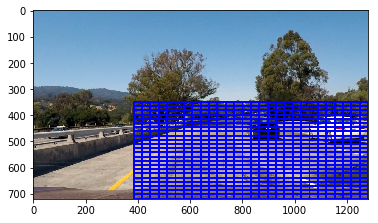

In [35]:
plt.imshow(test_img_boxes)

## Running Classifier On Windows

In [36]:
def find_hot_windows(img, sl_windows, normaliser, classifier, correct_prediction):
    """
    Identifies windows where our classifier "fired" a positive prediction    
    """
    hot_windows = []
    features = []
    for sl_window in sl_windows:
        top_left = sl_window[0]
        bottom_right = sl_window[1]
        img_window = img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0],:]
        img_window_resized = subsample_image(img_window, new_size=(64, 64), single_vector=False)
        img_window_features = compute_features(img_window_resized)
#        img_window_features_normalised = normaliser.transform(img_window_features)
        features.append(img_window_features)
#         prediction = classifier.predict(img_window_features_normalised.reshape(-1, 1))
#         print(prediction)
#         if prediction == correct_prediction:
#             hot_windows.append(sl_window)
        
    features_normalised, _ = normalise_features(features, normaliser=normaliser)
    predictions = classifier.predict(features_normalised)
    
    for (sl_window, pred) in zip(sl_windows, predictions):
        if pred == correct_prediction:
             hot_windows.append(sl_window)
    
    return hot_windows

In [48]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [117]:
def multi_scale_pipeline(img, x_start, x_stop, y_start, y_stop, scale, cfier, normaliser, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         window=64, color_space="RGB", correct_label="vehicle"):
    draw_img = np.copy(img)
    # Normalise our input image
    img = change_color_space(img, cspace=color_space).astype(np.float32)
        
    # Define the image portion we are interested in
    img_tosearch = img[y_start:y_stop, x_start:x_stop, :]
    ctrans_tosearch = img_tosearch
    
    # Subsample this search section if needed
    if scale != 1:
        imshape = ctrans_tosearch.shape 
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define the total number of cells in a given direction (x, y) 
    # This is equivalent to the number of convolutions per axis in deep learning (c.f. cs231n)
    # nxblock = [(axis_size - block_size) / stride] + 1 
    #  -> [(axis_size - pix_per_cell * cells_per_block) / pix_per_cell] + 1
    #  -> [(axis_size / pix_per_cell) - cells_per_block] + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    # Each cell within a block is normalised and produces a histogram of orient features
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # TODO - make this a parameter    
    # Same here - we use the convolution formula to figure out the number of blocks in the window
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Instead of overlap, define how many cells to step
    # TODO - make this a parameter
    # TODO add a '+1' to nxsteps and nysteps formulas
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #print("ypos=", ypos)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = subsample_image(subimg, new_size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = normaliser.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = cfier.predict(test_features)
            
            if test_prediction == correct_label:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bounding_boxes.append([(xbox_left + x_start, ytop_draw+y_start), (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start)])
                cv2.rectangle(draw_img,(xbox_left + x_start, ytop_draw+y_start),(xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start),(0,0,255),6) 
     
    return bounding_boxes
    #return draw_img

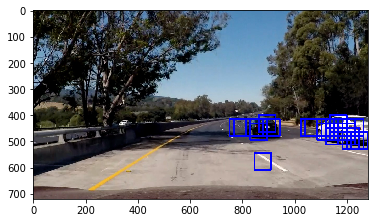

In [126]:
mc_bboxes = multi_scale_pipeline(test_imgs[4], 750, 1280, 400, 700, 1, classifier, normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64)
#print(mc_bboxes)
new_img_boxes = draw_boxes(test_imgs[4], mc_bboxes)
plt.imshow(new_img_boxes)

In [37]:
h_wins = find_hot_windows(test_imgs[0], s_windows, normaliser, classifier, "vehicle")

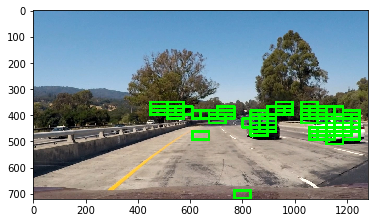

In [38]:
img_hot_windows = draw_boxes(test_imgs[0], h_wins, color=(0, 255, 0), thick=10)
plt.imshow(img_hot_windows)

## Heatmap Thresholding

In [102]:
from scipy.ndimage.measurements import label

In [103]:
def create_heatmap(img, bbox_list):
    """
    Returns a new heatmap where the regions of the image captured by the bounding boxes are "heated-up"
    """
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

In [104]:
def threshold_heatmap(heatmap, threshold=2):
    """
    Updates the heatmap by only retaining hot sections whose values are strictly above the threshold.
    All other values are "cooled" down
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [105]:
def label_heatmap(heatmap):
    """
    Returns a slice with labels over the original heatmap, as well as the total count of labels found
    """
    return label(heatmap)

In [106]:
def draw_smoothed_boxes(img, labels, duplicate=True):
    """
    Returns an image where bounding boxes have been drawn around the areas labeled.
    """
    
    copy = np.copy(img) if duplicate else img
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(copy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return copy

In [107]:
def smoothen_bounding_boxes(img, bboxes, thres=2):
    
    heat = create_heatmap(img, bboxes)
    heat_thresholded = threshold_heatmap(heat, threshold=thres)
    heat_labels = label_heatmap(heat_thresholded)
    img_smoothed_bboxes = draw_smoothed_boxes(img, heat_labels)
    
    return heat, heat_thresholded, heat_labels, img_smoothed_bboxes

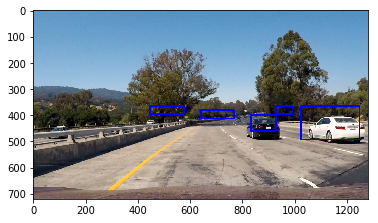

In [135]:
heatmap, heatmap_thres, heatmap_lbs, smoothed_cars_bboxes = smoothen_bounding_boxes(test_imgs[0], h_wins, thres=1)
plt.imshow(smoothed_cars_bboxes)


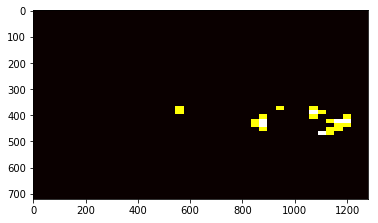

In [47]:
plt.imshow(heatmap, cmap="hot")

# Putting It All Together

In [171]:
class VehicleDetectorWithMemory:
    """
    The VehicleDetectorWithMemory is a class that is capable drawing bounding boxes around vehicles in a video
    """
    def __init__(self, classifier, normaliser, color_space="RGB"):
        self.classifier = classifier
        self.normaliser = normaliser
        self.color_space = color_space 
        
        # Add extra parameters such as [(ystart, ystop), (x_start, x_stop), scale] 
        # Maybe create a config object that has those and also classifier config?
        
    def process_image(self, img):
        """
        Returns a new image where the vehicles detected on the original image have been highlighted via a bounding box
        """

        bboxes_sc1 = np.asarray(multi_scale_pipeline(img, 750, 1280, 350, 700, 1, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64))
        bboxes_sc2 = np.asarray(multi_scale_pipeline(img, 750, 1280, 420, 700, 1.2, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64))
        bboxes_sc3 = np.asarray(multi_scale_pipeline(img, 750, 1280, 450, 700, 1.5, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64))
        bboxes_sc4 = np.asarray(multi_scale_pipeline(img, 750, 1280, 450, 700, 2, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64))
        bboxes_sc5 = np.asarray(multi_scale_pipeline(img, 750, 1280, 450, 700, 2.7, self.classifier, self.normaliser, 9, 8, 2, (32, 32), 32, color_space="RGB", window=64))
        
        combined_boxes = []
        for i, bboxes in enumerate([bboxes_sc1, bboxes_sc2, bboxes_sc3, bboxes_sc4, bboxes_sc5]):
            print(i, " ", bboxes.shape)
            if len(bboxes) == 0:
                continue
            combined_boxes = bboxes if len(combined_boxes) == 0 else np.concatenate((combined_boxes, bboxes), axis=0)
            
        #print("*** ", bboxes_sc1)
        #print("*** ", np.asarray(bboxes_sc1).shape)
        #combined_bboxes = np.concatenate((bboxes_sc1, bboxes_sc2, bboxes_sc3, bboxes_sc4, bboxes_sc5), axis=0)
        print("---- ", combined_boxes.shape)
        heatmap, heatmap_thres, heatmap_lbs, smoothed_cars_bboxes = smoothen_bounding_boxes(img, combined_boxes, thres=5)
        
        # TODO Convert heatmap to RGB (right now it is single channel)
        
        return smoothed_cars_bboxes

# Results

In [96]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [98]:
project_video_path = "project_video.mp4"
project_video_output_path = 'output_videos/project_video.mp4'

project_video_sample_path = 'project_video_sample.mp4'
project_video_sample_output_path = 'output_videos/project_video_sample.mp4'

## Sample Of Project Video

In [101]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 5, 10, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/eddieforson/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 5.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [172]:
detector = VehicleDetectorWithMemory(classifier, normaliser, color_space="RGB")

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)
[MoviePy] >>>> Building video output_videos/project_video_sample.mp4
[MoviePy] Writing video output_videos/project_video_sample.mp4


  1%|          | 1/125 [00:01<03:02,  1.47s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  2%|▏         | 2/125 [00:03<03:11,  1.55s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  2%|▏         | 3/125 [00:04<03:03,  1.51s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  3%|▎         | 4/125 [00:06<03:01,  1.50s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  4%|▍         | 5/125 [00:07<02:55,  1.46s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  5%|▍         | 6/125 [00:09<03:14,  1.63s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  6%|▌         | 7/125 [00:11<03:22,  1.71s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  6%|▋         | 8/125 [00:15<04:39,  2.38s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  7%|▋         | 9/125 [00:17<04:36,  2.39s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  8%|▊         | 10/125 [00:19<04:15,  2.22s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


  9%|▉         | 11/125 [00:20<03:44,  1.97s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 10%|▉         | 12/125 [00:23<03:53,  2.06s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 10%|█         | 13/125 [00:26<04:44,  2.54s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 11%|█         | 14/125 [00:28<04:22,  2.36s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 12%|█▏        | 15/125 [00:30<04:01,  2.20s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 13%|█▎        | 16/125 [00:32<03:42,  2.04s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 14%|█▎        | 17/125 [00:33<03:18,  1.84s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 14%|█▍        | 18/125 [00:35<03:05,  1.73s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 15%|█▌        | 19/125 [00:37<03:23,  1.92s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 16%|█▌        | 20/125 [00:39<03:22,  1.93s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 17%|█▋        | 21/125 [00:41<03:20,  1.93s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 18%|█▊        | 22/125 [00:43<03:16,  1.91s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 18%|█▊        | 23/125 [00:44<03:05,  1.81s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 19%|█▉        | 24/125 [00:46<03:00,  1.79s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 20%|██        | 25/125 [00:47<02:46,  1.66s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 21%|██        | 26/125 [00:49<02:34,  1.56s/it]

0   (19, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (39, 2, 2)


 22%|██▏       | 27/125 [00:50<02:25,  1.49s/it]

0   (18, 2, 2)
1   (12, 2, 2)
2   (5, 2, 2)
3   (3, 2, 2)
4   (3, 2, 2)
----  (41, 2, 2)


 22%|██▏       | 28/125 [00:52<02:25,  1.50s/it]

0   (17, 2, 2)
1   (15, 2, 2)
2   (5, 2, 2)
3   (7, 2, 2)
4   (1, 2, 2)
----  (45, 2, 2)


 23%|██▎       | 29/125 [00:53<02:15,  1.41s/it]

0   (26, 2, 2)
1   (17, 2, 2)
2   (12, 2, 2)
3   (6, 2, 2)
4   (2, 2, 2)
----  (63, 2, 2)


 24%|██▍       | 30/125 [00:54<02:09,  1.36s/it]

0   (30, 2, 2)
1   (29, 2, 2)
2   (12, 2, 2)
3   (8, 2, 2)
4   (1, 2, 2)
----  (80, 2, 2)


 25%|██▍       | 31/125 [00:55<02:05,  1.33s/it]

0   (28, 2, 2)
1   (18, 2, 2)
2   (10, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (63, 2, 2)


 26%|██▌       | 32/125 [00:57<02:04,  1.33s/it]

0   (25, 2, 2)
1   (14, 2, 2)
2   (8, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (51, 2, 2)


 26%|██▋       | 33/125 [00:58<02:00,  1.31s/it]

0   (24, 2, 2)
1   (14, 2, 2)
2   (6, 2, 2)
3   (2, 2, 2)
4   (1, 2, 2)
----  (47, 2, 2)


 27%|██▋       | 34/125 [00:59<02:04,  1.37s/it]

0   (18, 2, 2)
1   (16, 2, 2)
2   (7, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (45, 2, 2)


 28%|██▊       | 35/125 [01:01<01:59,  1.33s/it]

0   (20, 2, 2)
1   (11, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (38, 2, 2)


 29%|██▉       | 36/125 [01:02<01:55,  1.30s/it]

0   (22, 2, 2)
1   (14, 2, 2)
2   (3, 2, 2)
3   (1, 2, 2)
4   (1, 2, 2)
----  (41, 2, 2)


 30%|██▉       | 37/125 [01:03<01:54,  1.30s/it]

0   (25, 2, 2)
1   (17, 2, 2)
2   (7, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (53, 2, 2)


 30%|███       | 38/125 [01:05<01:52,  1.29s/it]

0   (25, 2, 2)
1   (16, 2, 2)
2   (8, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (53, 2, 2)


 31%|███       | 39/125 [01:06<01:50,  1.29s/it]

0   (27, 2, 2)
1   (21, 2, 2)
2   (9, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (61, 2, 2)


 32%|███▏      | 40/125 [01:07<01:47,  1.27s/it]

0   (27, 2, 2)
1   (21, 2, 2)
2   (11, 2, 2)
3   (8, 2, 2)
4   (1, 2, 2)
----  (68, 2, 2)


 33%|███▎      | 41/125 [01:08<01:49,  1.31s/it]

0   (32, 2, 2)
1   (22, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (75, 2, 2)


 34%|███▎      | 42/125 [01:10<01:47,  1.29s/it]

0   (44, 2, 2)
1   (27, 2, 2)
2   (17, 2, 2)
3   (4, 2, 2)
4   (1, 2, 2)
----  (93, 2, 2)


 34%|███▍      | 43/125 [01:11<01:44,  1.28s/it]

0   (36, 2, 2)
1   (33, 2, 2)
2   (16, 2, 2)
3   (6, 2, 2)
4   (0,)
----  (91, 2, 2)


 35%|███▌      | 44/125 [01:12<01:42,  1.27s/it]

0   (30, 2, 2)
1   (22, 2, 2)
2   (9, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (65, 2, 2)


 36%|███▌      | 45/125 [01:13<01:40,  1.26s/it]

0   (31, 2, 2)
1   (16, 2, 2)
2   (5, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (56, 2, 2)


 37%|███▋      | 46/125 [01:15<01:38,  1.24s/it]

0   (25, 2, 2)
1   (15, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (47, 2, 2)


 38%|███▊      | 47/125 [01:16<01:43,  1.32s/it]

0   (26, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (2, 2, 2)
4   (0,)
----  (44, 2, 2)


 38%|███▊      | 48/125 [01:17<01:39,  1.29s/it]

0   (27, 2, 2)
1   (12, 2, 2)
2   (4, 2, 2)
3   (5, 2, 2)
4   (2, 2, 2)
----  (50, 2, 2)


 39%|███▉      | 49/125 [01:19<01:37,  1.28s/it]

0   (31, 2, 2)
1   (16, 2, 2)
2   (6, 2, 2)
3   (4, 2, 2)
4   (2, 2, 2)
----  (59, 2, 2)


 40%|████      | 50/125 [01:20<01:36,  1.28s/it]

0   (31, 2, 2)
1   (23, 2, 2)
2   (7, 2, 2)
3   (2, 2, 2)
4   (1, 2, 2)
----  (64, 2, 2)


 41%|████      | 51/125 [01:21<01:34,  1.28s/it]

0   (31, 2, 2)
1   (20, 2, 2)
2   (8, 2, 2)
3   (5, 2, 2)
4   (1, 2, 2)
----  (65, 2, 2)


 42%|████▏     | 52/125 [01:22<01:33,  1.27s/it]

0   (37, 2, 2)
1   (20, 2, 2)
2   (8, 2, 2)
3   (5, 2, 2)
4   (2, 2, 2)
----  (72, 2, 2)


 42%|████▏     | 53/125 [01:24<01:30,  1.26s/it]

0   (36, 2, 2)
1   (21, 2, 2)
2   (11, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (77, 2, 2)


 43%|████▎     | 54/125 [01:25<01:32,  1.31s/it]

0   (40, 2, 2)
1   (21, 2, 2)
2   (13, 2, 2)
3   (5, 2, 2)
4   (2, 2, 2)
----  (81, 2, 2)


 44%|████▍     | 55/125 [01:26<01:30,  1.29s/it]

0   (39, 2, 2)
1   (23, 2, 2)
2   (11, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (80, 2, 2)


 45%|████▍     | 56/125 [01:27<01:27,  1.27s/it]

0   (35, 2, 2)
1   (17, 2, 2)
2   (7, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (64, 2, 2)


 46%|████▌     | 57/125 [01:29<01:24,  1.25s/it]

0   (39, 2, 2)
1   (19, 2, 2)
2   (5, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (68, 2, 2)


 46%|████▋     | 58/125 [01:30<01:24,  1.26s/it]

0   (31, 2, 2)
1   (13, 2, 2)
2   (5, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (54, 2, 2)


 47%|████▋     | 59/125 [01:31<01:23,  1.26s/it]

0   (38, 2, 2)
1   (14, 2, 2)
2   (4, 2, 2)
3   (2, 2, 2)
4   (0,)
----  (58, 2, 2)


 48%|████▊     | 60/125 [01:32<01:21,  1.25s/it]

0   (33, 2, 2)
1   (16, 2, 2)
2   (2, 2, 2)
3   (5, 2, 2)
4   (1, 2, 2)
----  (57, 2, 2)


 49%|████▉     | 61/125 [01:34<01:24,  1.31s/it]

0   (35, 2, 2)
1   (22, 2, 2)
2   (5, 2, 2)
3   (5, 2, 2)
4   (1, 2, 2)
----  (68, 2, 2)


 50%|████▉     | 62/125 [01:35<01:21,  1.29s/it]

0   (34, 2, 2)
1   (18, 2, 2)
2   (9, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (65, 2, 2)


 50%|█████     | 63/125 [01:36<01:20,  1.29s/it]

0   (35, 2, 2)
1   (20, 2, 2)
2   (11, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (75, 2, 2)


 51%|█████     | 64/125 [01:38<01:18,  1.28s/it]

0   (40, 2, 2)
1   (23, 2, 2)
2   (13, 2, 2)
3   (9, 2, 2)
4   (2, 2, 2)
----  (87, 2, 2)


 52%|█████▏    | 65/125 [01:39<01:15,  1.26s/it]

0   (45, 2, 2)
1   (26, 2, 2)
2   (10, 2, 2)
3   (8, 2, 2)
4   (1, 2, 2)
----  (90, 2, 2)


 53%|█████▎    | 66/125 [01:40<01:13,  1.24s/it]

0   (51, 2, 2)
1   (29, 2, 2)
2   (14, 2, 2)
3   (9, 2, 2)
4   (2, 2, 2)
----  (105, 2, 2)


 54%|█████▎    | 67/125 [01:41<01:11,  1.23s/it]

0   (50, 2, 2)
1   (30, 2, 2)
2   (18, 2, 2)
3   (9, 2, 2)
4   (0,)
----  (107, 2, 2)


 54%|█████▍    | 68/125 [01:42<01:08,  1.20s/it]

0   (43, 2, 2)
1   (25, 2, 2)
2   (9, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (84, 2, 2)


 55%|█████▌    | 69/125 [01:44<01:09,  1.25s/it]

0   (41, 2, 2)
1   (25, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (2, 2, 2)
----  (75, 2, 2)


 56%|█████▌    | 70/125 [01:45<01:07,  1.23s/it]

0   (39, 2, 2)
1   (17, 2, 2)
2   (4, 2, 2)
3   (1, 2, 2)
4   (0,)
----  (61, 2, 2)


 57%|█████▋    | 71/125 [01:46<01:06,  1.24s/it]

0   (25, 2, 2)
1   (11, 2, 2)
2   (3, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (42, 2, 2)


 58%|█████▊    | 72/125 [01:48<01:05,  1.24s/it]

0   (28, 2, 2)
1   (12, 2, 2)
2   (6, 2, 2)
3   (2, 2, 2)
4   (1, 2, 2)
----  (49, 2, 2)


 58%|█████▊    | 73/125 [01:49<01:06,  1.28s/it]

0   (32, 2, 2)
1   (10, 2, 2)
2   (5, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (50, 2, 2)


 59%|█████▉    | 74/125 [01:50<01:06,  1.31s/it]

0   (32, 2, 2)
1   (13, 2, 2)
2   (6, 2, 2)
3   (1, 2, 2)
4   (1, 2, 2)
----  (53, 2, 2)


 60%|██████    | 75/125 [01:52<01:07,  1.35s/it]

0   (32, 2, 2)
1   (15, 2, 2)
2   (8, 2, 2)
3   (6, 2, 2)
4   (0,)
----  (61, 2, 2)


 61%|██████    | 76/125 [01:53<01:04,  1.32s/it]

0   (41, 2, 2)
1   (18, 2, 2)
2   (7, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (73, 2, 2)


 62%|██████▏   | 77/125 [01:54<01:01,  1.29s/it]

0   (42, 2, 2)
1   (19, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (82, 2, 2)


 62%|██████▏   | 78/125 [01:55<00:58,  1.24s/it]

0   (39, 2, 2)
1   (26, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (86, 2, 2)


 63%|██████▎   | 79/125 [01:57<00:56,  1.23s/it]

0   (48, 2, 2)
1   (26, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (1, 2, 2)
----  (94, 2, 2)


 64%|██████▍   | 80/125 [01:58<00:54,  1.20s/it]

0   (46, 2, 2)
1   (28, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (1, 2, 2)
----  (94, 2, 2)


 65%|██████▍   | 81/125 [01:59<00:52,  1.19s/it]

0   (35, 2, 2)
1   (19, 2, 2)
2   (7, 2, 2)
3   (4, 2, 2)
4   (1, 2, 2)
----  (66, 2, 2)


 66%|██████▌   | 82/125 [02:00<00:53,  1.24s/it]

0   (29, 2, 2)
1   (19, 2, 2)
2   (5, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (57, 2, 2)


 66%|██████▋   | 83/125 [02:01<00:51,  1.24s/it]

0   (31, 2, 2)
1   (17, 2, 2)
2   (6, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (59, 2, 2)


 67%|██████▋   | 84/125 [02:03<00:51,  1.25s/it]

0   (34, 2, 2)
1   (13, 2, 2)
2   (7, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (57, 2, 2)


 68%|██████▊   | 85/125 [02:04<00:49,  1.25s/it]

0   (34, 2, 2)
1   (13, 2, 2)
2   (5, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (57, 2, 2)


 69%|██████▉   | 86/125 [02:05<00:49,  1.26s/it]

0   (37, 2, 2)
1   (16, 2, 2)
2   (3, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (60, 2, 2)


 70%|██████▉   | 87/125 [02:07<00:51,  1.35s/it]

0   (43, 2, 2)
1   (21, 2, 2)
2   (8, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (77, 2, 2)


 70%|███████   | 88/125 [02:08<00:48,  1.32s/it]

0   (42, 2, 2)
1   (24, 2, 2)
2   (11, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (82, 2, 2)


 71%|███████   | 89/125 [02:09<00:46,  1.28s/it]

0   (49, 2, 2)
1   (20, 2, 2)
2   (12, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (88, 2, 2)


 72%|███████▏  | 90/125 [02:10<00:43,  1.24s/it]

0   (40, 2, 2)
1   (22, 2, 2)
2   (11, 2, 2)
3   (9, 2, 2)
4   (1, 2, 2)
----  (83, 2, 2)


 73%|███████▎  | 91/125 [02:11<00:41,  1.21s/it]

0   (42, 2, 2)
1   (19, 2, 2)
2   (16, 2, 2)
3   (9, 2, 2)
4   (1, 2, 2)
----  (87, 2, 2)


 74%|███████▎  | 92/125 [02:13<00:39,  1.19s/it]

0   (44, 2, 2)
1   (21, 2, 2)
2   (12, 2, 2)
3   (7, 2, 2)
4   (1, 2, 2)
----  (85, 2, 2)


 74%|███████▍  | 93/125 [02:14<00:37,  1.18s/it]

0   (42, 2, 2)
1   (20, 2, 2)
2   (9, 2, 2)
3   (6, 2, 2)
4   (0,)
----  (77, 2, 2)


 75%|███████▌  | 94/125 [02:15<00:38,  1.23s/it]

0   (40, 2, 2)
1   (18, 2, 2)
2   (6, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (68, 2, 2)


 76%|███████▌  | 95/125 [02:16<00:37,  1.25s/it]

0   (40, 2, 2)
1   (12, 2, 2)
2   (7, 2, 2)
3   (6, 2, 2)
4   (0,)
----  (65, 2, 2)


 77%|███████▋  | 96/125 [02:18<00:36,  1.26s/it]

0   (38, 2, 2)
1   (15, 2, 2)
2   (9, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (67, 2, 2)


 78%|███████▊  | 97/125 [02:19<00:35,  1.26s/it]

0   (42, 2, 2)
1   (15, 2, 2)
2   (6, 2, 2)
3   (3, 2, 2)
4   (1, 2, 2)
----  (67, 2, 2)


 78%|███████▊  | 98/125 [02:20<00:34,  1.26s/it]

0   (37, 2, 2)
1   (15, 2, 2)
2   (8, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (65, 2, 2)


 79%|███████▉  | 99/125 [02:22<00:34,  1.34s/it]

0   (46, 2, 2)
1   (21, 2, 2)
2   (9, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (80, 2, 2)


 80%|████████  | 100/125 [02:23<00:32,  1.31s/it]

0   (42, 2, 2)
1   (23, 2, 2)
2   (10, 2, 2)
3   (2, 2, 2)
4   (1, 2, 2)
----  (78, 2, 2)


 81%|████████  | 101/125 [02:24<00:30,  1.29s/it]

0   (44, 2, 2)
1   (21, 2, 2)
2   (10, 2, 2)
3   (4, 2, 2)
4   (1, 2, 2)
----  (80, 2, 2)


 82%|████████▏ | 102/125 [02:25<00:28,  1.25s/it]

0   (39, 2, 2)
1   (20, 2, 2)
2   (12, 2, 2)
3   (8, 2, 2)
4   (2, 2, 2)
----  (81, 2, 2)


 82%|████████▏ | 103/125 [02:27<00:27,  1.25s/it]

0   (46, 2, 2)
1   (21, 2, 2)
2   (14, 2, 2)
3   (7, 2, 2)
4   (2, 2, 2)
----  (90, 2, 2)


 83%|████████▎ | 104/125 [02:28<00:25,  1.21s/it]

0   (40, 2, 2)
1   (27, 2, 2)
2   (15, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (89, 2, 2)


 84%|████████▍ | 105/125 [02:29<00:23,  1.20s/it]

0   (33, 2, 2)
1   (21, 2, 2)
2   (11, 2, 2)
3   (6, 2, 2)
4   (0,)
----  (71, 2, 2)


 85%|████████▍ | 106/125 [02:30<00:23,  1.25s/it]

0   (29, 2, 2)
1   (19, 2, 2)
2   (7, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (59, 2, 2)


 86%|████████▌ | 107/125 [02:32<00:22,  1.25s/it]

0   (28, 2, 2)
1   (16, 2, 2)
2   (4, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (51, 2, 2)


 86%|████████▋ | 108/125 [02:33<00:21,  1.26s/it]

0   (29, 2, 2)
1   (13, 2, 2)
2   (5, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (50, 2, 2)


 87%|████████▋ | 109/125 [02:34<00:20,  1.26s/it]

0   (40, 2, 2)
1   (11, 2, 2)
2   (5, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (59, 2, 2)


 88%|████████▊ | 110/125 [02:36<00:19,  1.32s/it]

0   (38, 2, 2)
1   (13, 2, 2)
2   (6, 2, 2)
3   (2, 2, 2)
4   (0,)
----  (59, 2, 2)


 89%|████████▉ | 111/125 [02:37<00:19,  1.36s/it]

0   (33, 2, 2)
1   (10, 2, 2)
2   (6, 2, 2)
3   (1, 2, 2)
4   (0,)
----  (50, 2, 2)


 90%|████████▉ | 112/125 [02:38<00:17,  1.32s/it]

0   (36, 2, 2)
1   (12, 2, 2)
2   (7, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (58, 2, 2)


 90%|█████████ | 113/125 [02:40<00:15,  1.31s/it]

0   (42, 2, 2)
1   (14, 2, 2)
2   (9, 2, 2)
3   (4, 2, 2)
4   (1, 2, 2)
----  (70, 2, 2)


 91%|█████████ | 114/125 [02:41<00:13,  1.26s/it]

0   (45, 2, 2)
1   (22, 2, 2)
2   (11, 2, 2)
3   (8, 2, 2)
4   (1, 2, 2)
----  (87, 2, 2)


 92%|█████████▏| 115/125 [02:42<00:12,  1.23s/it]

0   (51, 2, 2)
1   (26, 2, 2)
2   (12, 2, 2)
3   (6, 2, 2)
4   (1, 2, 2)
----  (96, 2, 2)


 93%|█████████▎| 116/125 [02:43<00:10,  1.20s/it]

0   (43, 2, 2)
1   (22, 2, 2)
2   (11, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (81, 2, 2)


 94%|█████████▎| 117/125 [02:44<00:09,  1.19s/it]

0   (56, 2, 2)
1   (26, 2, 2)
2   (12, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (98, 2, 2)


 94%|█████████▍| 118/125 [02:46<00:08,  1.25s/it]

0   (46, 2, 2)
1   (18, 2, 2)
2   (5, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (73, 2, 2)


 95%|█████████▌| 119/125 [02:47<00:07,  1.27s/it]

0   (31, 2, 2)
1   (15, 2, 2)
2   (3, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (53, 2, 2)


 96%|█████████▌| 120/125 [02:48<00:06,  1.27s/it]

0   (32, 2, 2)
1   (17, 2, 2)
2   (7, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (60, 2, 2)


 97%|█████████▋| 121/125 [02:49<00:05,  1.26s/it]

0   (36, 2, 2)
1   (11, 2, 2)
2   (7, 2, 2)
3   (2, 2, 2)
4   (0,)
----  (56, 2, 2)


 98%|█████████▊| 122/125 [02:51<00:04,  1.34s/it]

0   (38, 2, 2)
1   (18, 2, 2)
2   (9, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (70, 2, 2)


 98%|█████████▊| 123/125 [02:52<00:02,  1.35s/it]

0   (37, 2, 2)
1   (26, 2, 2)
2   (6, 2, 2)
3   (5, 2, 2)
4   (0,)
----  (74, 2, 2)


 99%|█████████▉| 124/125 [02:54<00:01,  1.54s/it]

0   (48, 2, 2)
1   (22, 2, 2)
2   (10, 2, 2)
3   (3, 2, 2)
4   (0,)
----  (83, 2, 2)


100%|██████████| 125/125 [02:55<00:00,  1.44s/it]

0   (49, 2, 2)
1   (21, 2, 2)
2   (8, 2, 2)
3   (4, 2, 2)
4   (0,)
----  (82, 2, 2)


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_sample.mp4 

CPU times: user 2min 36s, sys: 8.24 s, total: 2min 44s
Wall time: 2min 57s


In [173]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))